In [162]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
import math
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 100)

import xGils.xElo as xElo

# **Elo**

Will look for two different types of duel:
1. Aerial;
2. Dribble.

Dribble duels will produce dual Elo scores: Elo Dribble Attack and Elo Dribble Defence.

So we'll be coming out with three different Elo Scores / Ranks / Percentiles.

In [113]:
repo_kpi = r'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/PLAYER KPIs'

## **Loading Opta Data**

In [2]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT & xG/Bayesian_Opta_xT_xG.csv').drop(columns=['Unnamed: 0'])

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df)} rows loaded.\n')

3126182 rows loaded.

CPU times: user 19.8 s, sys: 2.7 s, total: 22.5 s
Wall time: 23.2 s


### **Creating Reference Dataframe of Players, Player Names, and Player Positions**

In [4]:
df_players = df.groupby(['playerId','playerName'])\
                .agg({'detailedPosition':'count'})\
                .reset_index()

df_player_positions = df.groupby(['playerId','position'])\
                .agg({'detailedPosition':'count'})\
                .reset_index()

## getting the most frequent player names per player (can get duplicates with very very slightly different punctuation)
df_players['nameRank'] = df_players.sort_values(['playerId','detailedPosition'], ascending=[True,False])\
                                        .groupby(['playerId'])\
                                        .cumcount()+1

## getting the most frequent positions per player
df_player_positions['positionRank'] = df_player_positions.sort_values(['playerId','detailedPosition'], ascending=[True,False])\
                                        .groupby(['playerId'])\
                                        .cumcount()+1

## picking the position that is most frequently used per player
df_players = df_players.merge(df_player_positions, how='inner', on='playerId')

df_players = df_players.loc[(df_players['positionRank'] == 1) & (df_players['nameRank'] == 1)]\
                        .drop(columns=['detailedPosition_x','detailedPosition_y','positionRank','nameRank'])\
                        .reset_index(drop=True)\
                        .copy()

## taking a look at the output reference dataframe for players and their position
df_players.head(20)

,playerId,playerName,position
0,1632,Gareth Barry,Midfielder
1,2404,Michael Carrick,Midfielder
2,2513,Jamie Murphy,Midfielder
3,3773,Peter Crouch,Forward
4,4126,Gianluigi Buffon,Goalkeeper
5,4232,Iker Casillas,Goalkeeper
6,5139,Roman Weidenfeller,Goalkeeper
7,5207,Craig Gordon,Goalkeeper
8,5589,Dean Whitehead,Midfielder
9,6744,Lee Grant,Goalkeeper


## Applying Patches to Player Positions

In [153]:
# Marcus Rashford is a Forward, not a Midfielder
df_players.loc[df_players['playerId'] == 176297, 'position'] = 'Forward'

# Gareth Bale is a Forward, not a Midfielder
df_players.loc[df_players['playerId'] == 36903, 'position'] = 'Forward'

## **Aerial Duels**

In [40]:
%%time

df_aerial_winner = df.loc[df['eventSubType'] == 'Aerial Duel']
df_aerial_loser = df.loc[df['eventSubType'] == 'Lost Aerial Duel']

dic = {}

# iterating through each winning aerial duel row
for idx, cols in df_aerial_winner.iterrows():
    
    # field names for the attacking duel
    competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition\
    ,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventId,eventType,eventSubType\
    ,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId\
    ,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,possessionTeamId,possessionSequenceIndex\
    ,possessionStartTime,possessionTimeSec,playerPossessionTimeSec,goalDelta,numReds,goalScoredFlag,xT,xG,excess_xG = cols
    
    # finding matching defensive duel candidates
    ## same match, different team, same half, within 10 seconds, and must happen in the same place
    df_candidates = df_aerial_loser.loc[(df_aerial_loser['matchId'] == matchId)\
                                & (df_aerial_loser['playerTeamId'] != playerTeamId)\
                                & (df_aerial_loser['periodId'] ==  periodId)\
                                & (df_aerial_loser['timeStamp'] >= timeStamp-pd.Timedelta(5,'s'))\
                                & (df_aerial_loser['timeStamp'] <= timeStamp+pd.Timedelta(5,'s'))\
                                & (df_aerial_loser['x1'] + x1 == 100)\
                                & (df_aerial_loser['y1'] + y1 ==  100)].copy()
    
    # pick best candidate
    df_candidates['deltaSec'] = abs( (df_candidates['timeStamp'] - timeStamp) / pd.Timedelta(1,'s') )
    
    # if there is a mapping
    if len(df_candidates) > 0:
        opp_eventId, opp_team_id, opp_player_name = df_candidates.sort_values('deltaSec').head(1)[['eventId','playerTeamId','playerName']].values[0]
        dic[eventId] = [eventId, opp_eventId]
        
        # update df_defend to get rid of things that have been selected
        # this will have a massive impact when you get into the latter stages of the algo
        df_aerial_loser = df_aerial_loser.loc[df_aerial_loser['eventId'] != opp_eventId]


CPU times: user 14min 57s, sys: 1min 49s, total: 16min 46s
Wall time: 15min 18s


In [154]:
# 98% match rate!
len(dic) / len(df_aerial_winner)

0.97706054092207

In [155]:
df_aerial_duels = pd.DataFrame.from_dict(dic, orient='index', columns=['winnerEventId','loserEventId'])

df_aerial_duels = df_aerial_duels.merge(df, how='inner', left_on='winnerEventId', right_on='eventId')\
        [['winnerEventId','loserEventId','season','matchId','playerId','playerName','playerTeamId']]\
        .rename(columns={'playerId':'winnerPlayerId','playerName':'winnerPlayerName','playerTeamId':'winnerTeamId'})\
        .merge(df, how='inner', left_on='loserEventId', right_on='eventId', suffixes=('','_'))\
        [['winnerEventId','season','matchId','winnerPlayerId','winnerPlayerName','winnerTeamId','playerId','playerName','playerTeamId']]\
        .rename(columns={'playerId':'loserPlayerId','playerName':'loserPlayerName','playerTeamId':'loserTeamId'})\
        .merge(df_players, how='inner', left_on='winnerPlayerId', right_on='playerId')\
        .rename(columns={'position':'winnerPosition'})\
        [['winnerEventId','season','matchId','winnerPlayerId','winnerPlayerName','winnerTeamId'\
          ,'loserPlayerId','loserPlayerName','loserTeamId','winnerPosition']]\
        .merge(df_players, how='inner', left_on='loserPlayerId', right_on='playerId')\
        .rename(columns={'position':'loserPosition'})\
        [['winnerEventId','season','matchId','winnerPlayerId','winnerPlayerName','winnerTeamId'\
          ,'loserPlayerId','loserPlayerName','loserTeamId','winnerPosition','loserPosition']]

# query to remove goalkeepers from the duels
df_aerial_duels_ex_gk = df_aerial_duels.loc[(df_aerial_duels['winnerPosition'] != 'Goalkeeper') &\
                                           (df_aerial_duels['loserPosition'] != 'Goalkeeper')]

# query to remove goalkeepers from the duels
df_aerial_duels_gk = df_aerial_duels.loc[~((df_aerial_duels['winnerPosition'] != 'Goalkeeper') &\
                                           (df_aerial_duels['loserPosition'] != 'Goalkeeper'))]

# taking a look at winning and losing duels
df_aerial_duels_ex_gk.head(20)

,winnerEventId,season,matchId,winnerPlayerId,winnerPlayerName,winnerTeamId,loserPlayerId,loserPlayerName,loserTeamId,winnerPosition,loserPosition
0,9,2017/18,918893,98745,Héctor Bellerín,3,51938,Marc Albrighton,13,Defender,Midfielder
1,1756151,2018/19,987958,20664,David Silva,43,51938,Marc Albrighton,13,Midfielder,Midfielder
3,1811417,2019/20,1059715,103192,Kurt Zouma,8,51938,Marc Albrighton,13,Defender,Midfielder
4,318517,2017/18,919022,105717,Arthur Masuaku,21,51938,Marc Albrighton,13,Defender,Midfielder
5,2749607,2020/21,2128452,56983,Matt Ritchie,4,51938,Marc Albrighton,13,Midfielder,Midfielder
6,2749280,2020/21,2128452,58845,Ciaran Clark,4,51938,Marc Albrighton,13,Defender,Midfielder
7,2750317,2020/21,2128452,58845,Ciaran Clark,4,51938,Marc Albrighton,13,Defender,Midfielder
8,2698983,2020/21,2128424,93264,Eric Dier,6,51938,Marc Albrighton,13,Midfielder,Midfielder
9,1280003,2018/19,987735,149266,Alfie Mawson,54,51938,Marc Albrighton,13,Defender,Midfielder
10,931893,2018/19,987619,58822,Cédric Soares,20,51938,Marc Albrighton,13,Defender,Midfielder


### **Aerial Duels: Excl. Goalkeepers**

#### **All Seasons**

In [156]:
%%time

## Elo initialisation settings
initial_rating = 100
k = 20

# creating data structure of winners and losers to be fed into Elo algo
winner_loser_outcome = [(i[0], i[1]) for i in df_aerial_duels_ex_gk.loc[:, ['winnerPlayerId','loserPlayerId']].values]

# producing de-duplicated list of playerId's
players = list(set(df_aerial_duels_ex_gk['winnerPlayerId'].values).union(set(df_aerial_duels_ex_gk['loserPlayerId'].values)))

# producing mElo dataframe
df_aerial_duels_ex_gk_elo = pd.DataFrame(xElo.mElo(players, initial_rating, k, winner_loser_outcome, 500), columns=['eloAerial'])

# transforming the index (which is the playerId) to a column that we can join on
df_aerial_duels_ex_gk_elo['playerId'] = df_aerial_duels_ex_gk_elo.index

# joining the playerId on the df_players reference dataframe to get the player names and positions out
df_aerial_duels_ex_gk_elo = df_aerial_duels_ex_gk_elo.merge(df_players)

# producing position-specific rank
df_aerial_duels_ex_gk_elo['positionEloAerialRank'] = df_aerial_duels_ex_gk_elo.sort_values(['position','eloAerial'], ascending=[True,False])\
                                                .groupby('position').cumcount() + 1

# producing position-specific percentiles
df_aerial_duels_ex_gk_elo['positionEloAerialPercentileRank'] = 100 - df_aerial_duels_ex_gk_elo.positionEloAerialRank.apply(lambda x: np.round(percentileofscore(df_aerial_duels_ex_gk_elo.positionEloAerialRank.values, x),1))

# rounding the Elo scores to the nearest Elo point
df_aerial_duels_ex_gk_elo['eloAerial'] = np.round(df_aerial_duels_ex_gk_elo.eloAerial, 0)

# and setting as ints
df_aerial_duels_ex_gk_elo['eloAerial'] = df_aerial_duels_ex_gk_elo.eloAerial.astype(int)

# providing season (All Seasons)
df_aerial_duels_ex_gk_elo['season'] = 'All Seasons'

# rejigging columns
df_aerial_duels_ex_gk_elo = df_aerial_duels_ex_gk_elo[['season','playerId','playerName','position','eloAerial','positionEloAerialRank','positionEloAerialPercentileRank']]


CPU times: user 55.9 s, sys: 424 ms, total: 56.3 s
Wall time: 56.8 s


#### **Season by Season**

In [157]:
%%time

# getting list of seasons (there are four)
seasons = df.season.drop_duplicates().sort_values().values

# Elo initialisation settings
initial_rating = 100
k = 20

# list of season Elo dataframes (will append to this and then concatenate it later)
lst_aerial_season_elo = []

for season in seasons:
    
    print (f'Processing {season}...')
    
    # iterating through dribbles season by season
    df_season = df_aerial_duels_ex_gk.loc[df_aerial_duels_ex_gk['season'] == season].copy()
    
    # creating data structure of winners and losers to be fed into Elo algo
    winner_loser_outcome = [(i[0], i[1]) for i in df_season.loc[:, ['winnerPlayerId','loserPlayerId']].values]

    # producing de-duplicated list of playerId's
    players = list(set(df_season['winnerPlayerId'].values).union(set(df_season['loserPlayerId'].values)))

    # producing mElo dataframe
    df_aerial_season_ex_gk_elo = pd.DataFrame(xElo.mElo(players, initial_rating, k, winner_loser_outcome, 500), columns=['eloAerial'])

    # transforming the index (which is the playerId) to a column that we can join on
    df_aerial_season_ex_gk_elo['playerId'] = df_aerial_season_ex_gk_elo.index

    # joining the playerId on the df_players reference dataframe to get the player names and positions out
    df_aerial_season_ex_gk_elo = df_aerial_season_ex_gk_elo.merge(df_players)
    
    df_aerial_season_ex_gk_elo['season'] = season

    # producing position-specific rank
    df_aerial_season_ex_gk_elo['positionEloAerialRank'] = df_aerial_season_ex_gk_elo.sort_values(['position','eloAerial'], ascending=[True,False])\
                                                    .groupby('position').cumcount() + 1

    # producing position-specific percentiles
    df_aerial_season_ex_gk_elo['positionEloAerialPercentileRank'] = 100 - df_aerial_season_ex_gk_elo.positionEloAerialRank.apply(lambda x: np.round(percentileofscore(df_aerial_season_ex_gk_elo.positionEloAerialRank.values, x),1))

    # rounding the Elo scores to the nearest Elo point
    df_aerial_season_ex_gk_elo['eloAerial'] = np.round(df_aerial_season_ex_gk_elo.eloAerial, 0)

    # and setting as ints
    df_aerial_season_ex_gk_elo['eloAerial'] = df_aerial_season_ex_gk_elo.eloAerial.astype(int)

    # rejigging columns
    df_aerial_season_ex_gk_elo = df_aerial_season_ex_gk_elo[['season','playerId','playerName','position','eloAerial','positionEloAerialRank','positionEloAerialPercentileRank']]

    
    # appending to dataframe list
    lst_aerial_season_elo.append(df_aerial_season_ex_gk_elo)

df_aerial_elo_seasons = pd.concat(lst_aerial_season_elo, ignore_index=True)

Processing 2017/18...
Processing 2018/19...
Processing 2019/20...
Processing 2020/21...
CPU times: user 51 s, sys: 347 ms, total: 51.4 s
Wall time: 51.8 s


### **Combining `All Seasons` and individual seasons**

In [158]:
df_aerial_elo = pd.concat([df_aerial_elo_seasons, df_aerial_duels_ex_gk_elo], ignore_index=True)

### Having a quick look at the distribution of Elo scores

* Symmetric around the mean
* Looks like they follow the logistic distribution (that's how the probabilities are calculated)

<AxesSubplot:>

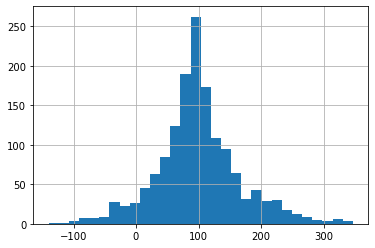

In [139]:
# and the bottom 10
df_aerial_duels_ex_gk_elo.eloAerial.hist(bins=30)

In [140]:
df_aerial_duels_ex_gk_elo.eloAerial.mean()

99.99933466400532

In [141]:
df_aerial_duels_ex_gk_elo.eloAerial.std()

66.89927738874509

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

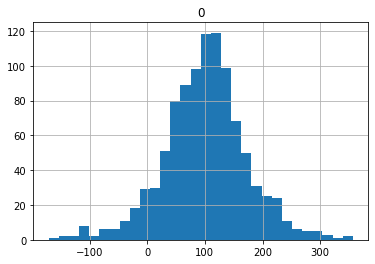

In [142]:
x = np.arange(-100, 300, 0.001)
y = np.random.logistic(loc=100, scale=40, size=1000)

pd.DataFrame(y).hist(bins=30)

### **Aerial Duels: Just Goalkeepers**

**Could explore this further, but due to time constraints, will focus analysis on outfield players.**

In [48]:
%%time

## Elo initialisation settings
initial_rating = 100
k = 20

# creating data structure of winners and losers to be fed into Elo algo
winner_loser_outcome = [(i[0], i[1]) for i in df_aerial_duels_gk.loc[:, ['winnerPlayerId','loserPlayerId']].values]

# producing de-duplicated list of playerId's
players = list(set(df_aerial_duels_gk['winnerPlayerId'].values).union(set(df_aerial_duels_gk['loserPlayerId'].values)))

# producing mElo dataframe
df_aerial_duels_gk_elo = pd.DataFrame(xElo.mElo(players, initial_rating, k, winner_loser_outcome, 500), columns=['eloScore'])

# transforming the index (which is the playerId) to a column that we can join on
df_aerial_duels_gk_elo['playerId'] = df_aerial_duels_gk_elo.index

# joining the playerId on the df_players reference dataframe to get the player names and positions out
df_aerial_duels_gk_elo = df_aerial_duels_gk_elo.merge(df_players)

df_aerial_duels_gk_elo = df_aerial_duels_gk_elo.loc[df_aerial_duels_gk_elo['position'] == 'Goalkeeper']

# taking a look at the top 20 goal keeper mElo scores
df_aerial_duels_gk_elo.head(20)

CPU times: user 973 ms, sys: 8.83 ms, total: 982 ms
Wall time: 984 ms


,eloScore,playerId,playerName,position
0,336.205396,111234,Jordan Pickford,Goalkeeper
1,333.588947,121160,Ederson,Goalkeeper
2,323.142735,58376,Alex McCarthy,Goalkeeper
3,297.592229,17745,Kasper Schmeichel,Goalkeeper
4,290.904654,116535,Alisson,Goalkeeper
5,282.018731,131897,Mat Ryan,Goalkeeper
6,282.017608,98747,Nick Pope,Goalkeeper
7,279.621412,67089,Martin Dubravka,Goalkeeper
8,275.119923,40836,Vicente Guaita,Goalkeeper
9,275.039585,37915,Hugo Lloris,Goalkeeper


<AxesSubplot:>

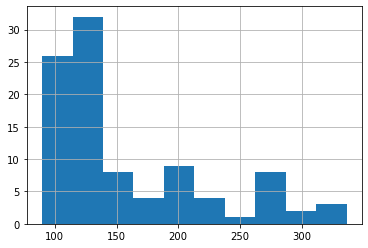

In [49]:
df_aerial_duels_gk_elo.eloScore.hist(bins=10)

---

## **Dribbles**

### **Dribble (attack) winners | Dribbled Past (defend) losers**

In [5]:
%%time

df_dribble_attack_winner = df.loc[df['eventSubType'] == 'Dribble']
df_dribble_defend_loser = df.loc[df['eventSubType'] == 'Dribbled Past']

dic_dribble_attack_winner_defend_loser = {}

# iterating through each winning aerial duel row
for idx, cols in df_dribble_attack_winner.iterrows():
    
    # field names for the attacking duel
    competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition\
    ,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventId,eventType,eventSubType\
    ,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId\
    ,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,possessionTeamId,possessionSequenceIndex\
    ,possessionStartTime,possessionTimeSec,playerPossessionTimeSec,goalDelta,numReds,goalScoredFlag,xT,xG,excess_xG = cols
    
    # finding matching defensive duel candidates
    ## same match, different team, same half, within 10 seconds, and must happen in the same place
    df_candidates = df_dribble_defend_loser.loc[(df_dribble_defend_loser['matchId'] == matchId)\
                                & (df_dribble_defend_loser['playerTeamId'] != playerTeamId)\
                                & (df_dribble_defend_loser['periodId'] ==  periodId)\
                                & (df_dribble_defend_loser['timeStamp'] >= timeStamp-pd.Timedelta(5,'s'))\
                                & (df_dribble_defend_loser['timeStamp'] <= timeStamp+pd.Timedelta(5,'s'))\
                                & (df_dribble_defend_loser['x1'] + x1 == 100)\
                                & (df_dribble_defend_loser['y1'] + y1 == 100)].copy()
    
    # pick best candidate
    df_candidates['deltaSec'] = abs( (df_candidates['timeStamp'] - timeStamp) / pd.Timedelta(1,'s') )
    
    # if there is a mapping
    if len(df_candidates) > 0:
        opp_eventId, opp_team_id, opp_player_name = df_candidates.sort_values('deltaSec').head(1)[['eventId','playerTeamId','playerName']].values[0]
        dic_dribble_attack_winner_defend_loser[eventId] = [eventId, opp_eventId]
        
        # update df_defend to get rid of things that have been selected
        # this will have a massive impact when you get into the latter stages of the algo
        df_dribble_defend_loser = df_dribble_defend_loser.loc[df_dribble_defend_loser['eventId'] != opp_eventId]

CPU times: user 6min 6s, sys: 38.1 s, total: 6min 44s
Wall time: 6min 14s


In [6]:
# Have mapped 96% of dribble winners to the losing defender!
len(dic_dribble_attack_winner_defend_loser) / len(df_dribble_attack_winner)

0.9641349588216194

In [7]:
len(dic_dribble_attack_winner_defend_loser)

32662

### **Producing Dataframe**

In [8]:
%%time

df_dribble_attack_winner_defend_loser = pd.DataFrame.from_dict(dic_dribble_attack_winner_defend_loser, orient='index', columns=['attackEventId','defenceEventId'])

df_dribble_attack_winner_defend_loser = df_dribble_attack_winner_defend_loser.merge(df, how='inner', left_on='attackEventId', right_on='eventId')\
        [['attackEventId','defenceEventId','season','matchId','playerId','playerName','playerTeamId','eventType','eventSubType']]\
        .rename(columns={'playerId':'attackPlayerId','playerName':'attackPlayerName','playerTeamId':'attackTeamId','eventType':'attackEventType','eventSubType':'attackEventSubType'})\
        .merge(df, how='inner', left_on='defenceEventId', right_on='eventId', suffixes=('','_'))\
        [['attackEventId','defenceEventId','season','matchId','attackPlayerId','attackPlayerName','attackTeamId','attackEventType','attackEventSubType','playerId','playerName','playerTeamId','eventType','eventSubType']]\
        .rename(columns={'playerId':'defencePlayerId','playerName':'defencePlayerName','playerTeamId':'defenceTeamId','eventType':'defenceEventType','eventSubType':'defenceEventSubType'})\
        .merge(df_players, how='inner', left_on='attackPlayerId', right_on='playerId')\
        .rename(columns={'position':'attackPosition'})\
        [['attackEventId','defenceEventId','season','matchId','attackPlayerId','attackPlayerName','attackTeamId','attackEventType','attackEventSubType'\
          ,'defencePlayerId','defencePlayerName','defenceTeamId','defenceEventType','defenceEventSubType']]

df_dribble_attack_winner_defend_loser['winnerPlayerId'] = df_dribble_attack_winner_defend_loser['attackPlayerId']
df_dribble_attack_winner_defend_loser['loserPlayerId'] = df_dribble_attack_winner_defend_loser['defencePlayerId']
df_dribble_attack_winner_defend_loser['dribbleOutcome'] = 1

df_dribble_attack_winner_defend_loser.head()

CPU times: user 2.15 s, sys: 403 ms, total: 2.55 s
Wall time: 2.58 s


,attackEventId,defenceEventId,season,matchId,attackPlayerId,attackPlayerName,attackTeamId,attackEventType,attackEventSubType,defencePlayerId,defencePlayerName,defenceTeamId,defenceEventType,defenceEventSubType,winnerPlayerId,loserPlayerId,dribbleOutcome
0,43,42,2017/18,918893,50175,Danny Welbeck,3,attack,Dribble,40725,Danny Simpson,13,defence,Dribbled Past,50175,40725,1
1,513,512,2017/18,918893,50175,Danny Welbeck,3,attack,Dribble,37402,Christian Fuchs,13,defence,Dribbled Past,50175,37402,1
2,70076,70075,2017/18,918934,50175,Danny Welbeck,3,attack,Dribble,41270,David Luiz,8,defence,Dribbled Past,50175,41270,1
3,382928,382927,2017/18,919034,50175,Danny Welbeck,3,attack,Dribble,40002,Matteo Darmian,1,defence,Dribbled Past,50175,40002,1
4,531016,531015,2017/18,919103,50175,Danny Welbeck,3,attack,Dribble,61603,Daniel Drinkwater,8,defence,Dribbled Past,50175,61603,1


### **Failed Dribble (attack) losers | Tackle (defend) winners**

> Have to be careful in these cases that we don't include neutral dribbles with a failed tackle.

In [9]:
%%time

df_dribble_attack_loser = df.loc[df['eventSubType'] == 'Failed Dribble']

# looks like 46% of failed dribbles
df_dribble_defend_winner =df.loc[df['eventSubType'].isin(['Tackle','Failed Tackle','Interception','Ball Claim','Ball Recovery'])]
#df_dribble_defend_winner = df.loc[df['eventType'].isin(['defence','press'])]

dic_dribble_defend_winner_attack_loser = {}

# iterating through each winning aerial duel row
for idx, cols in df_dribble_attack_loser.iterrows():
    
    # field names for the attacking duel
    competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition\
    ,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventId,eventType,eventSubType\
    ,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId\
    ,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,possessionTeamId,possessionSequenceIndex\
    ,possessionStartTime,possessionTimeSec,playerPossessionTimeSec,goalDelta,numReds,goalScoredFlag,xT,xG,excess_xG = cols
    
    # finding matching defensive duel candidates
    ## same match, different team, same half, within 10 seconds, and must happen in the same place
    df_candidates = df_dribble_defend_winner.loc[(df_dribble_defend_winner['matchId'] == matchId)\
                                & (df_dribble_defend_winner['playerTeamId'] != playerTeamId)\
                                & (df_dribble_defend_winner['periodId'] ==  periodId)\
                                & (df_dribble_defend_winner['timeStamp'] >= timeStamp-pd.Timedelta(5,'s'))\
                                & (df_dribble_defend_winner['timeStamp'] <= timeStamp+pd.Timedelta(5,'s'))\
                                & (df_dribble_defend_winner['x1'] + x1 == 100)\
                                & (df_dribble_defend_winner['y1'] + y1 == 100)].copy()
    
    # pick best candidate
    df_candidates['deltaSec'] = abs( (df_candidates['timeStamp'] - timeStamp) / pd.Timedelta(1,'s') )
    
    # if there is a mapping
    if len(df_candidates) > 0:
        opp_eventId, opp_team_id, opp_player_name = df_candidates.sort_values('deltaSec').head(1)[['eventId','playerTeamId','playerName']].values[0]
        dic_dribble_defend_winner_attack_loser[eventId] = [eventId, opp_eventId]
        
        # update df_defend to get rid of things that have been selected
        # this will have a massive impact when you get into the latter stages of the algo
        df_dribble_defend_winner = df_dribble_defend_winner.loc[df_dribble_defend_winner['eventId'] != opp_eventId]

CPU times: user 29min 17s, sys: 3min 17s, total: 32min 34s
Wall time: 29min 6s


In [10]:
# Have mapped 76% of dribble losers mapped
## 46% contribution -> from tackles
## 30% contribution from failed tackles -> i.e. a neutral engagement
len(dic_dribble_defend_winner_attack_loser) / len(df_dribble_attack_loser)

0.7613228894691035

In [11]:
len(dic_dribble_defend_winner_attack_loser)

21869

In [12]:
len(df_dribble_attack_loser)

28725

### **Producing Dataframe**

In [13]:
%%time

df_dribble_defend_winner_attack_loser = pd.DataFrame.from_dict(dic_dribble_defend_winner_attack_loser, orient='index', columns=['attackEventId','defenceEventId'])

df_dribble_defend_winner_attack_loser = df_dribble_defend_winner_attack_loser.merge(df, how='inner', left_on='attackEventId', right_on='eventId')\
        [['attackEventId','defenceEventId','season','matchId','playerId','playerName','playerTeamId','eventType','eventSubType']]\
        .rename(columns={'playerId':'attackPlayerId','playerName':'attackPlayerName','playerTeamId':'attackTeamId','eventType':'attackEventType','eventSubType':'attackEventSubType'})\
        .merge(df, how='inner', left_on='defenceEventId', right_on='eventId', suffixes=('','_'))\
        [['attackEventId','defenceEventId','season','matchId','attackPlayerId','attackPlayerName','attackTeamId','attackEventType','attackEventSubType','playerId','playerName','playerTeamId','eventType','eventSubType']]\
        .rename(columns={'playerId':'defencePlayerId','playerName':'defencePlayerName','playerTeamId':'defenceTeamId','eventType':'defenceEventType','eventSubType':'defenceEventSubType'})\
        .merge(df_players, how='inner', left_on='attackPlayerId', right_on='playerId')\
        .rename(columns={'position':'attackPosition'})\
        [['attackEventId','defenceEventId','season','matchId','attackPlayerId','attackPlayerName','attackTeamId','attackEventType','attackEventSubType'\
          ,'defencePlayerId','defencePlayerName','defenceTeamId','defenceEventType','defenceEventSubType']]

df_dribble_defend_winner_attack_loser['winnerPlayerId'] = df_dribble_defend_winner_attack_loser['defencePlayerId']
df_dribble_defend_winner_attack_loser['loserPlayerId'] = df_dribble_defend_winner_attack_loser['attackPlayerId']
df_dribble_defend_winner_attack_loser['dribbleOutcome'] = 0

# setting neutrals to outcome 0.5 and will not include them in the analysis
df_dribble_defend_winner_attack_loser.loc[df_dribble_defend_winner_attack_loser['defenceEventSubType'] == 'Failed Tackle', 'dribbleOutcome'] = 0.5

df_dribble_defend_winner_attack_loser.head()

CPU times: user 1.89 s, sys: 443 ms, total: 2.34 s
Wall time: 2.35 s


,attackEventId,defenceEventId,season,matchId,attackPlayerId,attackPlayerName,attackTeamId,attackEventType,attackEventSubType,defencePlayerId,defencePlayerName,defenceTeamId,defenceEventType,defenceEventSubType,winnerPlayerId,loserPlayerId,dribbleOutcome
0,257,258,2017/18,918893,98745,Héctor Bellerín,3,attack,Failed Dribble,37402,Christian Fuchs,13,defence,Failed Tackle,37402,98745,0.5
1,707,708,2017/18,918893,98745,Héctor Bellerín,3,attack,Failed Dribble,95658,Harry Maguire,13,defence,Tackle,95658,98745,0.0
2,39582,39583,2017/18,918917,98745,Héctor Bellerín,3,attack,Failed Dribble,112338,Emre Can,14,defence,Failed Tackle,112338,98745,0.5
3,40415,40416,2017/18,918917,98745,Héctor Bellerín,3,attack,Failed Dribble,100059,Alberto Moreno,14,defence,Tackle,100059,98745,0.0
4,40782,40783,2017/18,918917,98745,Héctor Bellerín,3,attack,Failed Dribble,100059,Alberto Moreno,14,defence,Tackle,100059,98745,0.0


### **Combining Dribble Dataframes to Produce: `df_dribble`**

In [16]:
df_dribble = pd.concat([df_dribble_defend_winner_attack_loser,df_dribble_attack_winner_defend_loser])

# only going to process outcomes of 0 or 1, not including neutral outcomes
df_dribble = df_dribble.loc[df_dribble['dribbleOutcome'] != 0.5].reset_index(drop=True).copy()

---

## **Running dual duel Elo algorithm for dribblers & dribble defenders**

In [104]:
%%time

## Elo initialisation settings
initial_rating = 100
k = 20

# creating data structure of winners and losers to be fed into Elo algo
winner_loser_outcome = [(i[0], i[1], i[2]) for i in df_dribble.loc[:, ['winnerPlayerId','loserPlayerId','dribbleOutcome']].values]

# producing de-duplicated list of playerId's
players = list(set(df_dribble['winnerPlayerId'].values).union(set(df_dribble['loserPlayerId'].values)))

# producing mElo dataframe
df_dribble_elo = xElo.mElo_attack_defence(players, initial_rating, k, winner_loser_outcome, 500)

# joining on the player ref table
df_dribble_elo = df_dribble_elo.merge(df_players, how='inner', left_on='player', right_on='playerId')\
                    [['playerId','playerName','position','eloAttack','eloDefence','eloDribbleRank','eloDribbleDefenceRank']]

# producing position-specific rank
df_dribble_elo['positionEloDribbleRank'] = df_dribble_elo.sort_values(['position','eloAttack'], ascending=[True,False])\
                                            .groupby('position').cumcount() + 1

df_dribble_elo['positionEloDribbleDefenceRank'] = df_dribble_elo.sort_values(['position','eloDefence'], ascending=[True,False])\
                                            .groupby('position').cumcount() + 1

# producing position-specific percentiles
df_dribble_elo['positionEloDribblePercentileRank'] = 100 - df_dribble_elo.positionEloDribbleRank.apply(lambda x: np.round(percentileofscore(df_dribble_elo.positionEloDribbleRank.values, x),1))
df_dribble_elo['positionEloDribbleDefencePercentileRank'] = 100 - df_dribble_elo.positionEloDribbleDefenceRank.apply(lambda x: np.round(percentileofscore(df_dribble_elo.positionEloDribbleDefenceRank.values, x),1))

# rounding the Elo scores to the nearest Elo point
df_dribble_elo['eloAttack'] = np.round(df_dribble_elo.eloAttack, 0)
df_dribble_elo['eloDefence'] = np.round(df_dribble_elo.eloDefence, 0)

# and setting as ints
df_dribble_elo['eloAttack'] = df_dribble_elo.eloAttack.astype(int)
df_dribble_elo['eloDefence'] = df_dribble_elo.eloDefence.astype(int)

# providing season (All Seasons)
df_dribble_elo['season'] = 'All Seasons'

# rejigging columns
df_dribble_elo = df_dribble_elo[['season','playerId','playerName', 'position', 'eloAttack', 'eloDefence',
                                'eloDribbleRank', 'eloDribbleDefenceRank', 'positionEloDribbleRank',
                                'positionEloDribbleDefenceRank', 'positionEloDribblePercentileRank',
                                'positionEloDribbleDefencePercentileRank']]

df_dribble_elo.head(20)

CPU times: user 3min 41s, sys: 1.32 s, total: 3min 42s
Wall time: 3min 44s


,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
0,All Seasons,91651,Mateo Kovacic,Midfielder,364,54,1,1100,1,363,99.8,30.1
1,All Seasons,27789,Fernandinho,Midfielder,340,69,2,942,2,284,99.6,41.0
2,All Seasons,231372,Tanguy Ndombele,Midfielder,339,37,3,1201,3,421,99.3,22.6
3,All Seasons,204480,Declan Rice,Midfielder,334,73,4,905,4,266,99.1,44.5
4,All Seasons,62399,Dusan Tadic,Midfielder,331,-48,5,1474,5,615,98.8,3.4
5,All Seasons,62398,Nemanja Matic,Midfielder,329,44,6,1164,6,399,98.6,25.5
6,All Seasons,159533,Adama Traoré,Forward,328,74,7,894,1,144,99.8,67.9
7,All Seasons,175592,Naby Keita,Midfielder,325,-39,8,1456,7,604,98.3,4.1
8,All Seasons,39104,Mousa Dembélé,Midfielder,323,26,9,1254,8,457,98.0,18.0
9,All Seasons,54102,Jack Wilshere,Midfielder,320,-19,10,1411,9,572,97.8,6.1


---

### **Producing Percentiles per Position per Season**

In [122]:
%%time

# getting list of seasons (there are four)
seasons = df.season.drop_duplicates().sort_values().values

# Elo initialisation settings
initial_rating = 100
k = 20

# list of season Elo dataframes (will append to this and then concatenate it later)
lst_season_elo = []

for season in seasons:
    
    print (f'Processing {season}...')
    
    # iterating through dribbles season by season
    df_season = df_dribble.loc[df_dribble['season'] == season].copy()
    
    # creating data structure of winners and losers to be fed into Elo algo
    winner_loser_outcome = [(i[0], i[1], i[2]) for i in df_season.loc[:, ['winnerPlayerId','loserPlayerId','dribbleOutcome']].values]

    # producing de-duplicated list of playerId's
    players = list(set(df_season['winnerPlayerId'].values).union(set(df_season['loserPlayerId'].values)))

    # producing mElo dataframe
    df_season_elo = xElo.mElo_attack_defence(players, initial_rating, k, winner_loser_outcome, 500)
    
    df_season_elo['season'] = season

    # joining on the player ref table
    df_season_elo = df_season_elo.merge(df_players, how='inner', left_on='player', right_on='playerId')\
                        [['season','playerId','playerName','position','eloAttack','eloDefence','eloDribbleRank','eloDribbleDefenceRank']]

    # producing position-specific rank
    df_season_elo['positionEloDribbleRank'] = df_season_elo.sort_values(['position','eloAttack'], ascending=[True,False])\
                                                .groupby('position').cumcount() + 1

    df_season_elo['positionEloDribbleDefenceRank'] = df_season_elo.sort_values(['position','eloDefence'], ascending=[True,False])\
                                                .groupby('position').cumcount() + 1

    # producing position-specific percentiles
    df_season_elo['positionEloDribblePercentileRank'] = 100 - df_season_elo.positionEloDribbleRank.apply(lambda x: np.round(percentileofscore(df_season_elo.positionEloDribbleRank.values, x),1))
    df_season_elo['positionEloDribbleDefencePercentileRank'] = 100 - df_season_elo.positionEloDribbleDefenceRank.apply(lambda x: np.round(percentileofscore(df_season_elo.positionEloDribbleDefenceRank.values, x),1))

    # rounding the Elo scores to the nearest Elo point
    df_season_elo['eloAttack'] = np.round(df_season_elo.eloAttack, 0)
    df_season_elo['eloDefence'] = np.round(df_season_elo.eloDefence, 0)

    # and setting as ints
    df_season_elo['eloAttack'] = df_season_elo.eloAttack.astype(int)
    df_season_elo['eloDefence'] = df_season_elo.eloDefence.astype(int)

    # rejigging columns
    df_season_elo = df_season_elo[['season','playerId','playerName', 'position', 'eloAttack', 'eloDefence',
                                    'eloDribbleRank', 'eloDribbleDefenceRank', 'positionEloDribbleRank',
                                    'positionEloDribbleDefenceRank', 'positionEloDribblePercentileRank',
                                    'positionEloDribbleDefencePercentileRank']]
    
    # appending to dataframe list
    lst_season_elo.append(df_season_elo)

df_dribble_elo_seasons = pd.concat(lst_season_elo, ignore_index=True)
    

Processing 2017/18...
Processing 2018/19...
Processing 2019/20...
Processing 2020/21...
CPU times: user 3min 31s, sys: 834 ms, total: 3min 32s
Wall time: 3min 33s


### **Combining `All Seasons` and individual seasons**

In [123]:
df_elo = pd.concat([df_dribble_elo_seasons, df_dribble_elo], ignore_index=True)

### **Taking a look at the data**

In [124]:
df_elo.loc[df_elo['position'] == 'Forward'].head(20)

,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
1,2017/18,42786,Eden Hazard,Forward,330,-21,2,829,1,160,99.7,41.5
6,2017/18,37265,Alexis Sánchez,Forward,299,-95,7,875,2,170,99.3,38.1
8,2017/18,92217,Roberto Firmino,Forward,284,-134,9,877,3,171,98.8,37.7
10,2017/18,47431,Willian,Forward,272,-14,11,820,4,155,98.3,43.2
16,2017/18,59966,Alexandre Lacazette,Forward,254,-37,17,850,5,165,97.9,39.8
25,2017/18,118748,Mohamed Salah,Forward,243,-50,26,858,6,168,97.4,38.8
33,2017/18,41464,Marko Arnautovic,Forward,234,71,34,519,7,88,97.0,66.1
35,2017/18,57134,Salomón Rondón,Forward,232,-36,36,846,8,163,96.5,40.5
45,2017/18,14937,Cristiano Ronaldo,Forward,220,74,46,491,9,80,96.1,68.9
51,2017/18,66749,Romelu Lukaku,Forward,214,-4,52,806,10,151,95.6,44.6


In [125]:
# Sterling
df_elo.loc[df_elo['playerId'] == 103955]

,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
75,2017/18,103955,Raheem Sterling,Forward,202,-48,76,855,20,167,91.0,39.1
908,2018/19,103955,Raheem Sterling,Forward,214,-19,32,957,7,181,97.3,41.4
1958,2019/20,103955,Raheem Sterling,Forward,188,-16,89,423,18,73,85.3,50.0
2369,2020/21,103955,Raheem Sterling,Forward,233,86,22,176,3,23,97.8,81.6
2938,All Seasons,103955,Raheem Sterling,Forward,213,-93,118,1529,17,285,95.7,40.8


In [126]:
# Rashford
df_elo.loc[df_elo.playerName.str.contains('Rashford')]

,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
238,2017/18,176297,Marcus Rashford,Forward,146,34,239,717,52,123,78.4,54.2
1377,2018/19,176297,Marcus Rashford,Forward,113,-42,501,975,96,184,67.1,40.5
2125,2019/20,176297,Marcus Rashford,Forward,124,58,256,283,48,41,65.7,70.1
2515,2020/21,176297,Marcus Rashford,Forward,146,-7,168,422,31,77,76.5,47.4
3441,All Seasons,176297,Marcus Rashford,Forward,128,-70,621,1510,113,275,73.9,42.7


In [127]:
# Mane
df_elo.loc[df_elo['playerId'] == 110979]

,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
68,2017/18,110979,Sadio Mané,Forward,204,-22,69,830,16,161,92.9,41.2
976,2018/19,110979,Sadio Mané,Forward,172,4,100,922,20,171,92.1,44.4
1907,2019/20,110979,Sadio Mané,Forward,223,35,38,338,6,55,95.3,61.3
2394,2020/21,110979,Sadio Mané,Forward,207,16,47,389,9,69,92.7,52.4
2976,All Seasons,110979,Sadio Mané,Forward,202,-32,156,1444,30,251,92.4,47.3


In [128]:
# Salah
df_elo.loc[df_elo['playerId'] == 118748]

,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
25,2017/18,118748,Mohamed Salah,Forward,243,-50,26,858,6,168,97.4,38.8
965,2018/19,118748,Mohamed Salah,Forward,174,26,89,872,16,163,93.7,46.8
1960,2019/20,118748,Mohamed Salah,Forward,188,-2,91,399,19,67,84.4,53.8
2527,2020/21,118748,Mohamed Salah,Forward,143,59,180,275,32,37,75.9,72.7
3019,All Seasons,118748,Mohamed Salah,Forward,191,-100,199,1536,36,289,90.9,40.0


In [129]:
df_elo.loc[df_elo['positionEloDribbleRank'] < 10].sort_values(['position','season','positionEloDribbleRank'])

,season,playerId,playerName,position,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,positionEloDribbleRank,positionEloDribbleDefenceRank,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
4,2017/18,95658,Harry Maguire,Defender,314,146,5,16,1,14,99.7,93.8
20,2017/18,41823,Fabian Delph,Defender,250,96,21,240,2,153,99.3,43.9
28,2017/18,171287,Joseph Gomez,Defender,239,78,29,451,3,239,98.8,22.2
30,2017/18,167075,Wesley Hoedt,Defender,238,180,31,3,4,3,98.3,98.8
31,2017/18,74230,Patrick van Aanholt,Defender,237,76,32,463,5,243,97.9,21.3
38,2017/18,149266,Alfie Mawson,Defender,228,120,39,66,6,56,97.4,77.1
44,2017/18,54484,Kiko Femenía,Defender,221,106,45,136,7,103,97.0,61.0
47,2017/18,58621,Kyle Walker,Defender,218,80,48,435,8,230,96.5,24.2
57,2017/18,154043,Ainsley Maitland-Niles,Defender,210,57,58,609,9,287,96.1,11.2
886,2018/19,234908,Juan Foyth,Defender,243,159,10,13,1,12,99.7,95.3


### **Aerial Data**

In [160]:
df_aerial_elo

,season,playerId,playerName,position,eloAerial,positionEloAerialRank,positionEloAerialPercentileRank
0,2017/18,103192,Kurt Zouma,Defender,338,1,99.8
1,2017/18,97032,Virgil van Dijk,Defender,322,2,99.4
2,2017/18,17761,James Tarkowski,Defender,310,3,99.0
3,2017/18,3773,Peter Crouch,Forward,291,1,99.8
4,2017/18,19419,Gary Cahill,Defender,291,4,98.7
...,...,...,...,...,...,...,...
4220,All Seasons,172632,Demarai Gray,Midfielder,-96,651,0.3
4221,All Seasons,85971,Son Heung-Min,Midfielder,-100,652,0.2
4222,All Seasons,223340,Bukayo Saka,Midfielder,-102,653,0.1
4223,All Seasons,109322,Jesse Lingard,Midfielder,-113,654,0.1


## **Outputting data to CSV**

In [163]:
# player reference data (which includes some patches for position)
df_players.to_csv(os.path.join(repo_kpi, 'df_players.csv'), index=None)

# dribble elo
df_elo.to_csv(os.path.join(repo_kpi, 'df_dribble_elo.csv'), index=None)

# aerial elo (excluding goalkeepers)
df_aerial_elo.to_csv(os.path.join(repo_kpi, 'df_aerial_elo.csv'), index=None)